In [1]:
import numpy as np
import itertools
from copy import deepcopy
from scipy.stats  import multivariate_normal
import matplotlib 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from IPython.core.debugger import set_trace
import random

In [26]:
class Stochastic_Schelling(object):

    def __init__(self, grid_size= (20, 20), empty_percentage= 0.3, threshold = 0.7, sim_range = 0.2, mu= 3.8, sigma=0.4):
        '''
        Inputs:
        
        grid_size: tuple (int, int). Size of the "population". Default (20, 20) 
        empty_percentage: float. Percent of cells that are empty. Default (0.3)
        threshold: float. Similarity threshold. Default: 0.7
        sim_range = float. Range in which the cell will consider "similar" income. Default 0.2
        mu= float. Mean for income log normal distribution. Default: 3.8
        sigma= float. Standard deviation for income log normal distribution. Default: 0.4
        moore: whether to consider a Moore neighborhood. Default: False (Von Neumann neighborhood)
        
        '''
        self.grid_size = grid_size
        self.empty_percentage = empty_percentage
        self.sim_range= sim_range
        self.threshold = threshold
        self.mu= mu
        self.sigma = sigma

        
        #variables
        self.income = np.ones(grid_size) #output a ndarray
        self.neighbour_counts = {}
        self.neighbour_avg = {}
        self.unsatisfied_cells = {}
        
        #populate 
        self.populate(empty_percentage, grid_size, mu, sigma)
        
        #count empty cells 
        self.init_neighbour_counts()
        self.init_neighbour_avg()
        self.step = 0
    
        
        self.avg_income_system=[]
        self.density_system=[]
        self.min_income = []
        self.max_income = []
        
        
    def populate(self, empty_percentage, grid_size, mu, sigma):
        '''
        Populate the grid.
        
        '''
        
        #if all the cells are empty, just return an empty grid
        if empty_percentage == 1:
            return 
        
        #populate the cells:
            #gaussian distribution for income
            #age start at 0
       
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                    
                    
                self.income[x][y]= np.random.lognormal(self.mu, self.sigma, 1)                               
                #we can modify for different distribution can be gaussian centered or skewed
        
        #given the empty cells percentage
        #we randomly empty some cells
        empty_grid = np.random.choice(range(grid_size[0]*grid_size[1]), round(empty_percentage * grid_size[0]* grid_size[1]), replace= False)
        

        for i in empty_grid:
            self.income[i % grid_size[0]][i // grid_size[0]] = None
    
    
    def display(self):
        '''
        Plot the state of the model.
        '''
        plt.figure()
        plt.imshow(self.income)
        plt.colorbar()
        plt.title('Step: ' + str(self.step) + ', Avg Income = ' + str(float("{0:.2f}".format(self.get_avg_val(self.income, self.grid_size)))))

    
    def correlation_mx(self, grid_size, income, moore=False):
        '''
        Return a correlation matrix given the shared neighbours
        '''
        correlation_matrix= []
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                correlation_matrix.append([])
                for m in range(self.grid_size[0]):
                    for n in range(self.grid_size[1]):

                        shared_neighbours= 0
                        if moore:
                            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
                        else:
                            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]

                        for x, y in combinations:
                            x_coordinate = (i + x) % len(self.income)
                            y_coordinate = (j + y) % len(self.income[0])

                            for p, q in combinations:
                                x_coor = (m + p) % len(self.income)
                                y_coor = (n + q) % len(self.income[0])


                            if not np.isnan(self.income[x_coordinate][y_coordinate]) and not np.isnan(self.income[x_coor][y_coor]) and self.income[x_coordinate][y_coordinate]== self.income[x_coor][y_coor]:
                                shared_neighbours += 1
                            if self.income[x_coordinate][y_coordinate]== self.income[m][n] or self.income[x_coor][y_coor]== self.income[i][j]:
                                shared_neighbours += 1



                        correlation_matrix[len(correlation_matrix) - 1].append(shared_neighbours/20)
        return correlation_matrix
    
    
    def is_satisfied(self, income, grid_size, threshold, sim_range, moore=False):
        '''
        We measured whether the cell is satisfied in its neighborhood. We get a the dict, 
        with a list of cells unsatified and their satisfaction ratio.

        '''
        self.unsatisfied_cells = dict()
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                
                if not np.isnan(self.income[x][y]):
                    similar = 0
                    different = 0
                    
                    if moore:
                        combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
                    else:
                        combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]

                    for i, j in combinations:
                        x_coordinate = (x + i) % len(income)
                        y_coordinate = (y + j) % len(income[0])

                        if not np.isnan(self.income[x_coordinate][y_coordinate]):
                            if self.income[x][y]*-self.sim_range+self.income[x][y] <= self.income[x_coordinate][y_coordinate]<= self.income[x][y]+self.income[x][y]*self.sim_range:
                                similar +=1
                            else:
                                different +=1

                    if (similar + different) == 0: 
                        self.unsatisfied_cells[(x, y)] = 0.5
                        
                    else:
                        if float(similar)/(similar+different) < self.threshold:
                            self.unsatisfied_cells[(x, y)] = (similar)/(similar+different)

                    
    
    def get_min_val(self, income):
        '''
        Return the minimum income value.
        
        '''
        
        return np.nanmin(self.income)
    
        
    def get_max_val(self, income):
        '''
        Return the maximum income value.
        
        '''
        
        return np.nanmax(self.income)
    
    def count_neighbours(self, income, x_spc, y_spc, moore=False):
        '''
        Return number of neighbours of a specific cell.
        
        '''
        neighbours= 0
        
        if moore:
            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
        else:
            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]
            
        for x, y in combinations:
            x_coordinate = (x_spc + x) % len(income)
            y_coordinate = (y_spc + y) % len(income[0])
            
            if not np.isnan(income[x_coordinate][y_coordinate]):
                neighbours += 1
                
        return neighbours
    
    def avg_neighbors_income(self, income, x_spc, y_spc, moore=False):
        '''
        Return average income of the neighbours of a specific cell.
        
        '''
        neighbours = self.count_neighbours(income, x_spc, y_spc)
        if moore:
            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
        else:
            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]
            
        value=0
        for x, y in combinations:
            x_coordinate = (x_spc + x) % len(income)
            y_coordinate = (y_spc + y) % len(income[0])
            
            if not np.isnan(income[x_coordinate][y_coordinate]):
                value += income[x_coordinate][y_coordinate]
        
        if neighbours==0:
            return 0
        else:
            return value/neighbours
    
    def init_neighbour_avg(self):
        '''
        avg income of neighbors in each cell if empty 
        
        '''        
        
        #we are having a dict with the avg of income of each empty cell
        for x in range(len(self.income)):
            for y in range(len(self.income[0])):
                if np.isnan(self.income[x][y]):
                    avg = self.avg_neighbors_income(self.income, x, y)
                    self.neighbour_avg[(x, y)] = avg
    
        
        
    def init_neighbour_counts(self):
        '''
        Counts the number of neighbors in each cell if empty 
        
        '''        
        
        #we are having a dict with the number of neighbors of each empty cell
        for x in range(len(self.income)):
            for y in range(len(self.income[0])):
                if np.isnan(self.income[x][y]):
                    count = self.count_neighbours(self.income, x, y)
                    self.neighbour_counts[(x, y)] = count
                    
                    
    def update_neighbour_avg(self, income, x_spc, y_spc, update_value, moore=False):
        '''
        Update neighbourhood counts given the new state. 
        New parameters:
            update_value: int. Change in the neighbour count.
            
        '''
        if moore:
            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
        else:
            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        if update_value <0:
            self.neighbour_avg[x_spc, y_spc]= self.avg_neighbors_income(income, x_spc, y_spc)
    
            
        else: 
            for x, y in combinations:
                x_coordinate = (x_spc + x)% len(income)
                y_coordinate = (y_spc + y)% len(income[0])

                if np.isnan(income[x_coordinate][y_coordinate]):
                    self.neighbour_avg[(x_coordinate, y_coordinate)] = self.avg_neighbors_income(income, x_coordinate, y_coordinate)

    
    def update_neighbour_counts(self, income, x_spc, y_spc, update_value, moore=False):
        '''
        
        New parameters:
            update_value: int. Change in the neighbour count.
            
        '''
        if moore:
            combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
        else:
            combinations = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        if update_value <0:
            self.neighbour_counts[x_spc, y_spc]= self.count_neighbours(income, x_spc, y_spc)
            
        for x, y in combinations:
            x_coordinate = (x_spc + x)% len(income)
            y_coordinate = (y_spc + y)% len(income[0])
            
            if np.isnan(income[x_coordinate][y_coordinate]):
                self.neighbour_counts[(x_coordinate, y_coordinate)] = self.count_neighbours(income, x_coordinate, y_coordinate)
                
                
    def get_min_val_index(self):
        '''
        Returns the index of the minimum state value. (float)
        
        '''
        return np.argmin(self.income)
    
    
    def get_avg_val(self, income, grid_size):
        '''
        Returns the average of state value. (float)
        
        '''
        
        #make a list of non-null value of state values
        no_null = []
        for x in range(grid_size[0]):
            for y in range(grid_size[1]):
                if not np.isnan(self.income[x][y]):
                    no_null.append(self.income[x][y])
        
        if len(no_null)!=0:
            return np.mean(no_null)
        
        #if all cells are empty, return 0
        else:
            return 0
    
    
    def has_empty(self):
        '''
        Returns True if there is an empty cell. (Boolean)
        
        '''
        empty = np.where(np.isnan(self.income))
        
        if not empty[0].any():
            return False
        else:
            return True
        
        
    def get_density(self):
        '''
        Returns density of current state. (Float)
        If empty, then -1
        
        '''
        no_null_size = np.sum(not np.isnan(self.state))
        
        if no_null_size !=0:
            return no_null_size/(self.grid_size[0]*self.grid_size[1])
        return -1
    
    
    def move_cell(self):
        '''
        Fills a cell with a higher fitting value. Update the states
        
        '''
        #we find the most unsatisfied cells
        self.is_satisfied(self.income, self.grid_size, self.threshold, self.sim_range)

        #we select one randomly 
        min_sim = []
        for k, v in self.unsatisfied_cells.items(): 
            if v == np.nanmin(list(self.unsatisfied_cells.values())): 
                min_sim.append(k)
                
        n= random.choice(min_sim)
        x_r= int(n[0])
        y_r= int(n[1])
        m= self.income[x_r][y_r]
        if np.isnan(m):
            set_trace()


        #list indexes of empty cells
        empty_cells = list(self.neighbour_avg.keys())

        #neighborhood income avg for empty cell
        neighbour_avg = self.neighbour_avg.values()
        
        #probabilities of moving to empty cell, given avg income
        #without normalization- numerator:
      
        neighbour_avg= (np.array(list(neighbour_avg))-m)**2
        
        #probabilities with normalization (w/denominator):
#         numerator = (neighbour_count - self.a * neighbour_avg)**2
        numerator = (np.nanmax(self.income)- neighbour_avg)**2
        probabilities = numerator / np.sum(numerator)

        #choose an empty cell to fill given the probabilities
        empty_choice= empty_cells[np.random.choice(range(len(probabilities)), p= probabilities)]
        
        
        self.income[empty_choice[0]][empty_choice[1]]= m
        
        self.income[x_r][y_r] = None
        
        #remove the cell from empty list
        self.neighbour_counts.pop((empty_choice[0], empty_choice[1]), None)
        
        
        #update the avg of the empty neighbours of the new occupied cell
        self.update_neighbour_counts(self.income, empty_choice[0], empty_choice[1], 1)
        self.update_neighbour_avg(self.income, empty_choice[0], empty_choice[1], 1)
        
        #update neighbour counts of the new empty space 
        self.update_neighbour_counts(self.income, x_r, y_r, -1)
        self.update_neighbour_avg(self.income, x_r, y_r, -1)
        
        
        
    def update_grid(self):
        
        new_state = deepcopy(self.income)
        
        #getting an array size N, 0.1 on values
        mean = np.ones(self.grid_size[0]*self.grid_size[1])*0.01
        
        
        #getting the fluctuations as a multivariate normal distribution with respect to the correlation matrix
        fluctuations = np.random.multivariate_normal(mean, self.correlation_mx(self.grid_size, self.income))
        
        #reshaping to a matrix
        fluctuations = np.reshape(fluctuations, (self.grid_size[0],self.grid_size[1]))
        
        
        #we update the new state of the grid
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                if not np.isnan(self.income[x][y]):
                    new_state[x][y] = self.income[x][y]+ self.income[x][y] * fluctuations[x][y]


        #save the state.
        self.income = new_state
        
        self.avg_income_system.append(self.get_avg_val(self.income, self.grid_size))
        self.min_income.append(self.get_min_val(self.income))
        self.max_income.append(self.get_max_val(self.income))
        
        
        self.step += 1

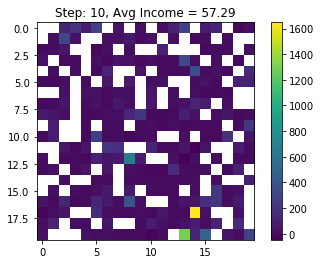

In [36]:
sim = Stochastic_Schelling()
for _ in range(10):
    sim.move_cell()
    sim.update_grid()
    
sim.display()


plt.show()

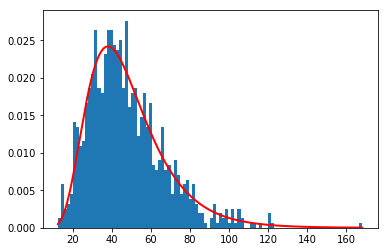

In [4]:
mu, sigma = 3.8, 0.4 # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)


import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
        / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

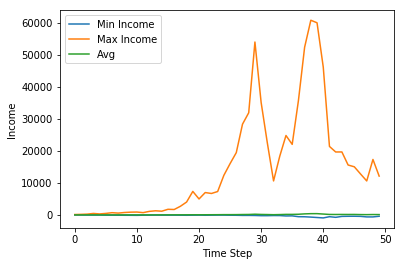

In [35]:
plt.plot(range(sim.step), sim.min_income, label='Min Income')
plt.plot(range(sim.step), sim.max_income, label='Max Income')
plt.plot(range(sim.step), sim.avg_income_system, label='Avg')

plt.ylabel('Income')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [ ]:
sims = [Stochastic_Schelling(threshold= 0.3),
        Stochastic_Schelling(threshold= 0.5),
        Stochastic_Schelling(threshold= 0.7),
        Stochastic_Schelling(threshold= 0.9)]


for sim in sims:
    for _ in range(10):
        sim.move_cell()
        sim.update_grid()
    plt.plot(range(sim.step),sim.min_income, label = 'Threshold = {}'.format(sim.threshold))

plt.legend(fontsize=8, loc=4)
plt.xlabel('Timestep')
plt.ylabel('Income')
plt.show()


In [ ]:
sims = [Stochastic_Schelling(threshold= 0.3),
        Stochastic_Schelling(threshold= 0.5),
        Stochastic_Schelling(threshold= 0.7),
        Stochastic_Schelling(threshold= 0.9)]


for sim in sims:
    for _ in range(10):
        sim.move_cell()
        sim.update_grid()
    plt.plot(range(sim.step),sim.max_income, label = 'Threshold = {}'.format(sim.threshold))

plt.legend(fontsize=8, loc=4)
plt.xlabel('Timestep')
plt.ylabel('Income')
plt.show()

In [ ]:
sims = [Stochastic_Schelling(threshold= 0.3),
        Stochastic_Schelling(threshold= 0.5),
        Stochastic_Schelling(threshold= 0.7),
        Stochastic_Schelling(threshold= 0.9)]


for sim in sims:
    for _ in range(10):
        sim.move_cell()
        sim.update_grid()
    plt.plot(range(sim.step),sim.avg_income_system, label = 'Threshold = {}'.format(sim.threshold))

plt.legend(fontsize=8, loc=4)
plt.xlabel('Timestep')
plt.ylabel('Income')
plt.show()